In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx

from sklearn.linear_model import LinearRegression

In [3]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

Load underground activity data
==============================

In [4]:
ug_activity = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_underground_activity.csv'))

In [5]:
ug_activity.head()

,year,nlc,station,area,weekday_entry,weekday_exit,saturday_entry,saturday_exit,sunday_entry,sunday_exit,annual_entry_and_exit
0,2007,500,Acton Town,Ealing,9205,8899.0,6722,6320,4427,4304,5.77
1,2007,502,Aldgate,City of London,9887,10397.0,2191,2587,1484,1772,5.57
2,2007,503,Aldgate East,Tower Hamlets,12820,12271.0,7040,6220,5505,5000,7.66
3,2007,505,Alperton,Brent,4611,4719.0,3354,3450,2433,2503,3.01
4,2007,506,Amersham,Chiltern,4182,3938.0,1709,1585,1004,957,2.34


In [6]:
area_annual_act = ug_activity.pivot_table(index='area', columns='year', values='annual_entry_and_exit', aggfunc=np.sum)

In [7]:
area_annual_act.head()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
area,,,,,,,,,,,
Barking and Dagenham,22.77,22.29,23.74,24.41,25.76,26.68,28.14,29.98,31.154386,31.15,33.62
Barnet,44.58,47.17,48.18,49.51,51.37,50.31,50.43,56.07,59.198246,61.25,63.56
Brent,79.77,79.75,77.18,74.68,78.07,81.43,84.65,90.88,94.158019,96.47,98.09
Camden,237.24,243.57,245.91,255.75,267.96,275.81,285.25,304.79,315.279853,309.28,308.83
Chiltern,4.08,3.81,3.63,3.67,3.91,4.02,3.84,4.73,4.599944,4.92,5.12


Find difference in slopes before and after olympics
===================================================

In [8]:
before_olympics = area_annual_act.loc[:, :2012]
after_olympics = area_annual_act.loc[:, 2012:]

In [9]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [10]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [11]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / area_annual_act.mean(axis=1)

In [50]:
all_slopes = area_annual_act.apply(get_slope, axis=1)

A few visualizations of raw data
================================

In [12]:
area_annual_act.index

Index(['Barking and Dagenham', 'Barnet', 'Brent', 'Camden', 'Chiltern',
       'City of London', 'City of Westminster', 'Ealing', 'Enfield',
       'Epping Forest', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Merton', 'Newham', 'Redbridge',
       'Richmond', 'Southwark', 'Three Rivers', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Watford'],
      dtype='object', name='area')

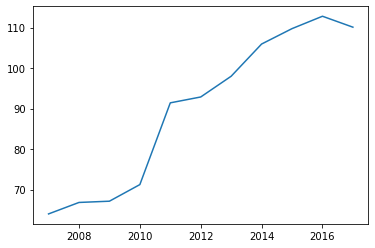

In [13]:
plt.plot(area_annual_act.loc['Newham'])

In [14]:
slopes.loc['Newham']

before    6.349143
after     3.839561
diff     -0.027882
Name: Newham, dtype: float64

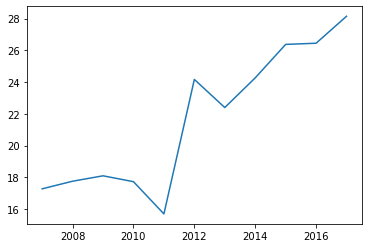

In [15]:
plt.plot(area_annual_act.loc['Greenwich'])

In [16]:
slopes.loc['Greenwich']

before    0.797143
after     0.975916
diff      0.008249
Name: Greenwich, dtype: float64

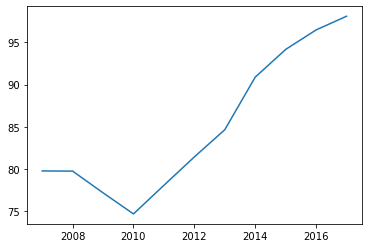

In [17]:
plt.plot(area_annual_act.loc['Brent'])

In [18]:
slopes.loc['Brent']

before    0.021714
after     3.486801
diff      0.040760
Name: Brent, dtype: float64

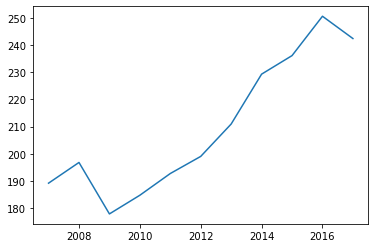

In [19]:
plt.plot(area_annual_act.loc['City of London'])

In [20]:
slopes.loc['City of London']

before    1.254571
after     9.787711
diff      0.040638
Name: City of London, dtype: float64

Load london borough shape data
==============================

In [21]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [22]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [23]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [24]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [25]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


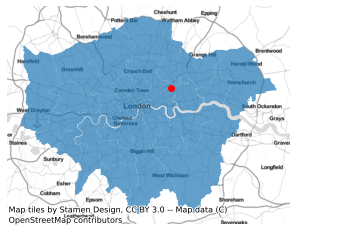

In [41]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [27]:
merged = map_df.set_index('NAME').join(area_annual_act)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


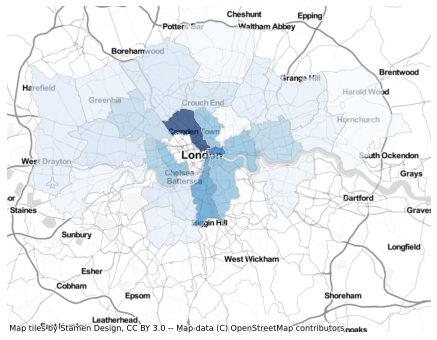

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=2017, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [29]:
merged_diffs = map_df.set_index('NAME').join(slopes)

In [44]:
merged_diffs['before'] = merged_diffs['before'] / area_annual_act.mean(axis=1)

In [52]:
merged_diffs['before']

NAME
Kingston upon Thames           NaN
Croydon                        NaN
Bromley                        NaN
Hounslow                  0.017707
Ealing                   -0.001643
Havering                  0.014120
Hillingdon                0.020143
Harrow                    0.001776
Brent                     0.000255
Barnet                    0.023008
Lambeth                   0.026565
Southwark                 0.024455
Lewisham                       NaN
Greenwich                 0.036783
Bexley                         NaN
Enfield                  -0.003778
Waltham Forest            0.015208
Redbridge                 0.032519
Sutton                         NaN
Richmond upon Thames           NaN
Merton                   -0.012756
Wandsworth               -0.002979
Hammersmith and Fulham    0.019740
Kensington and Chelsea    0.012360
Westminster                    NaN
Camden                    0.028429
Tower Hamlets             0.022986
Islington                 0.016309
Hackney        

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


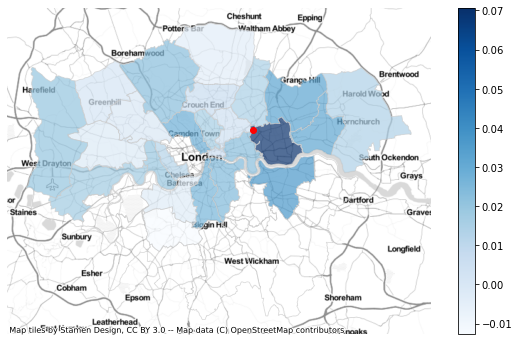

In [46]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged_diffs.plot(column='before', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend='bottomright', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig('test.png')

In [51]:
merged_alls = map_df.set_index('NAME').join(all_slopes)

ValueError: Other Series must have a name

In [44]:
merged_diffs['before'] = merged_diffs['before'] / area_annual_act.mean(axis=1)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


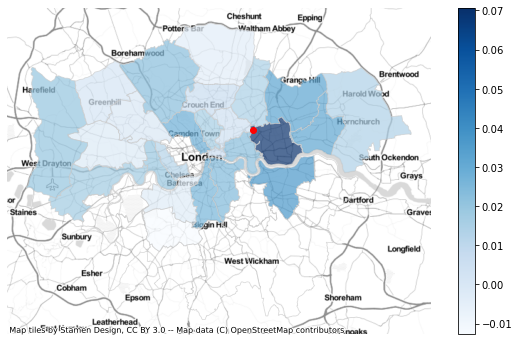

In [46]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged_diffs.plot(column='before', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend='bottomright', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig('test.png')

In [47]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [48]:
slopes.join(dists).corr()

,before,after,diff,Distance
before,1.000000,0.514330,-0.546186,-0.385700
after,0.514330,1.000000,0.054568,-0.286388
diff,-0.546186,0.054568,1.000000,0.332451
Distance,-0.385700,-0.286388,0.332451,1.000000


In [33]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [34]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                         -0.047848
Average_Age,_2017                                     0.426406
Proportion_of_population_aged_0-15,_2015             -0.082056
Proportion_of_population_of_working-age,_2015        -0.254432
Proportion_of_population_aged_65_and_over,_2015       0.414490
New_migrant_(NINo)_rates,_(2015/16)                   0.022955
Employment_rate_(%)_(2015)                            0.212351
%_of_employment_that_is_in_public_sector_(2014)      -0.191967
Jobs_Density,_2015                                    0.259844
Number_of_active_businesses,_2015                     0.105001
Two-year_business_survival_rates_(started_in_2013)    0.165384
Number_of_cars,_(2011_Census)                         0.295840
Number_of_cars_per_household,_(2011_Census)           0.344952
%_children_living_in_out-of-work_households_(2015)   -0.449230
Life_satisfaction_score_2011-14_(out_of_10)          -0.009534
Worthwhileness_score_2011-14_(out_of_10)             -0